## Dependencies

In [1]:
# Importing Classifier Modules
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.tree._tree import TREE_LEAF
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

## Download Dataset

* Run the following script only if you are running this jupyter notebook on Google colab.

In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html

# Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': '1fwkQQssDeDvwNCGeQfqruitVEz4_yy32'})
downloaded.GetContentFile('data.csv')

ImportError: No module named google.colab

In [ ]:
import pandas as pd

df = pd.read_csv('data.csv')

# Extract Title (Mr, Mrs, etc) from name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, 
                 "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, 
                 "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
df['Title'] = df['Title'].map(title_mapping)
# delete unnecessary feature from dataset
df.drop('Name', axis=1, inplace=True)
# map sex to binary value.
sex_mapping = {"male": 0, "female": 1}
df['Sex'] = df['Sex'].map(sex_mapping)
# fill missing age with median age for each title (Mr, Mrs, Miss, Others)
df["Age"].fillna(df.groupby("Title")["Age"].transform("median"), 
                 inplace=True)

# Binning/Converting Numerical Age to Categorical Variable  
df.loc[ df['Age'] <= 16, 'Age'] = 0,
df.loc[(df['Age'] > 16) & (df['Age'] <= 26), 'Age'] = 1,
df.loc[(df['Age'] > 26) & (df['Age'] <= 36), 'Age'] = 2,
df.loc[(df['Age'] > 36) & (df['Age'] <= 62), 'Age'] = 3,
df.loc[ df['Age'] > 62, 'Age'] = 4

# Embark
df['Embarked'] = df['Embarked'].fillna('S')
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
df['Embarked'] = df['Embarked'].map(embarked_mapping)

# Fare
df["Fare"].fillna(df.groupby("Pclass")["Fare"].transform("median"), 
                  inplace=True)

df.loc[ df['Fare'] <= 17, 'Fare'] = 0,
df.loc[(df['Fare'] > 17) & (df['Fare'] <= 30), 'Fare'] = 1,
df.loc[(df['Fare'] > 30) & (df['Fare'] <= 100), 'Fare'] = 2,
df.loc[ df['Fare'] > 100, 'Fare'] = 3

# Cabin
df['Cabin'] = df['Cabin'].str[:1]
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, 
                 "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
df['Cabin'] = df['Cabin'].map(cabin_mapping)
df["Cabin"].fillna(df.groupby("Pclass")["Cabin"].transform("median"), 
                   inplace=True)
# Family Size
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 
                  6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
df['FamilySize'] = df['FamilySize'].map(family_mapping)

features_drop = ['Ticket', 'SibSp', 'Parch']
df = df.drop(features_drop, axis=1)
df = df.drop(['PassengerId'], axis=1)

# Data
y = df['Survived'].values
X = df.drop('Survived', axis=1).values

## Modelling

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Testing score")

    plt.legend(loc="best")
    return plt

def prune_dt(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF

    if inner_tree.children_left[index] != TREE_LEAF:
        prune_dt(inner_tree, inner_tree.children_left[index], threshold)
        prune_dt(inner_tree, inner_tree.children_right[index], threshold)

# Machine Learning Algorithms

### Cross Validation (K-fold)

In [ ]:
k_fold = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

### kNN

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 9)
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
plot_learning_curve(clf, "Titanic", X, y, None, cv=k_fold, n_jobs=4)
plt.show()

max_depth = []
scores_mean = []
scores_std = []
for _ in range(1, 50, 5):
  clf = KNeighborsClassifier(n_neighbors = _)
  cv_score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='accuracy')
  scores_mean.append(cv_score.mean())
  scores_std.append(cv_score.std())
  max_depth.append(_)
plot_mean_std(max_depth, scores_mean, scores_std, 
              'Cross Validation Score', 'Titanic', 'k', 'Score')
plt.show()

In [85]:
# kNN Score
round(np.mean(score)*100, 2)

83.02

[0.81005587 0.78212291 0.81005587 0.74860335 0.84357542 0.8547486
 0.82681564 0.83240223 0.8547486  0.86592179]


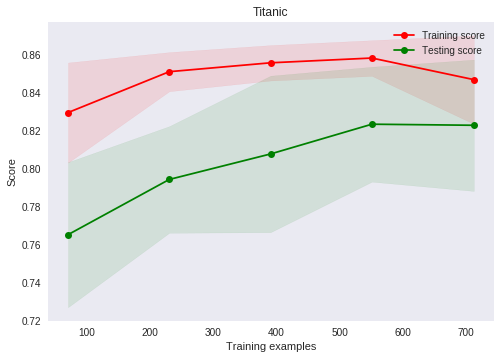

In [20]:
clf = KNeighborsClassifier(n_neighbors = 5)
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
plot_learning_curve(clf, "Titanic", X, y, None, cv=k_fold, n_jobs=4)
plt.show()

In [21]:
# kNN Score
round(np.mean(score)*100, 2)

82.29

### Decision Tree

#### Pruning

In [73]:
clf = DecisionTreeClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)

pred_prev = clf.predict(X_test)

print (X_train)
# index, threshold
prune_dt(clf.tree_, 0, 2)

pred_after = clf.predict(X_test)

print ("Accuracy before pruning ", accuracy_score(y_test, pred_prev))
print ("Accuracy after pruning ", accuracy_score(y_test, pred_after))

[[3.  0.  0.  ... 0.  3.  2. ]
 [3.  1.  3.  ... 0.  2.  2.4]
 [1.  1.  3.  ... 1.  2.  0. ]
 ...
 [3.  1.  2.  ... 1.  2.  0.8]
 [3.  0.  1.  ... 0.  0.  0. ]
 [2.  1.  3.  ... 0.  2.  0.4]]
('Accuracy before pruning ', 0.8324022346368715)
('Accuracy after pruning ', 0.8379888268156425)


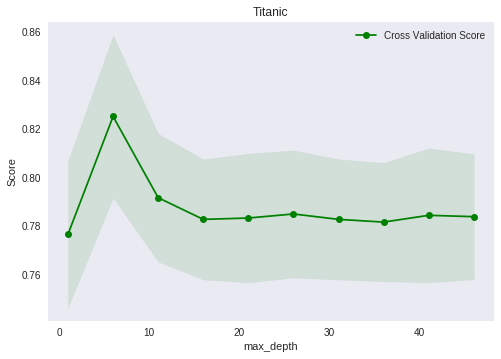

[0.7877095  0.73743017 0.80446927 0.74301676 0.76536313 0.7877095
 0.78212291 0.81564246 0.79329609 0.7877095 ]


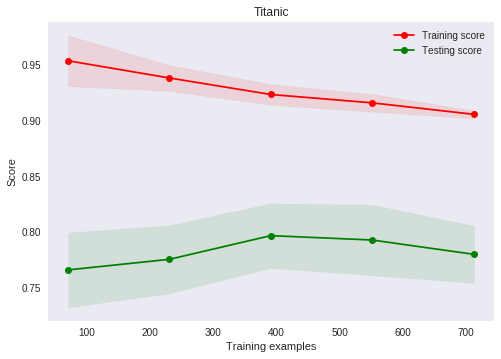

In [106]:
def plot_mean_std(x, y_mean, y_std, label, title, xlabel, ylabel):
  plt.figure()
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  
  plt.grid()
  
  y_mean = np.array(y_mean)
  y_std = np.array(y_std)
  plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.1, color="g")
  plt.plot(x, y_mean, 'o-', color="g", label=label)

  plt.legend(loc="best")

max_depth = []
scores_mean = []
scores_std = []
for _ in range(1, 50, 5):
  clf = DecisionTreeClassifier(max_depth=_)
  cv_score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='accuracy')
  scores_mean.append(cv_score.mean())
  scores_std.append(cv_score.std())
  max_depth.append(_)
plot_mean_std(max_depth, scores_mean, scores_std, 
              'Cross Validation Score', 'Titanic', 'max_depth', 'Score')
plt.show()


clf = DecisionTreeClassifier()
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='accuracy')
print(score)
plot_learning_curve(clf, "Learning curve:Titanic", X, y, None, cv=k_fold, n_jobs=4)
plt.show()

In [107]:
# Decision Tree Score
round(np.mean(score)*100, 2)

78.04

### Boosting

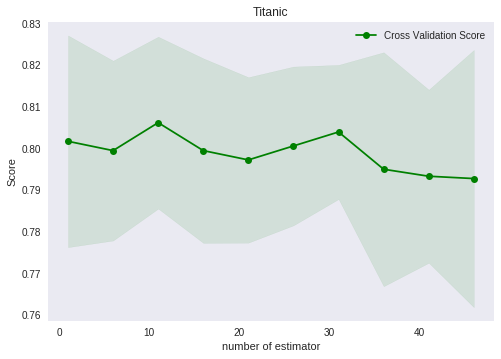

[0.79888268 0.77094972 0.80446927 0.78212291 0.82681564 0.83240223
 0.7877095  0.82122905 0.79329609 0.83240223]


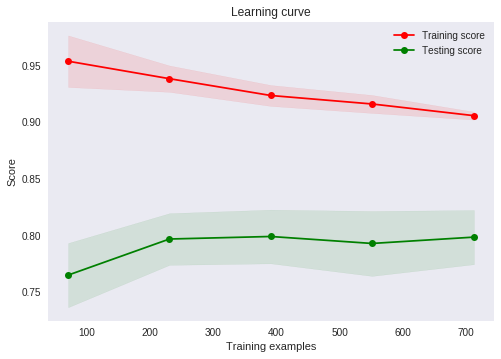

In [114]:
if __name__ == '__main__':
  max_depth = []
  scores_mean = []
  scores_std = []
  for _ in range(1, 50, 5):
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth= 10, random_state=0), 
                           learning_rate=0.5, n_estimators= _ * 1)
    cv_score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='accuracy')
    scores_mean.append(cv_score.mean())
    scores_std.append(cv_score.std())
    max_depth.append(_)
  plot_mean_std(max_depth, scores_mean, scores_std, 
              'Cross Validation Score', 'Titanic', 'number of estimator', 'Score')
  plt.show()
  
  
  clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, random_state=0), 
                           learning_rate=0.5, n_estimators=300)
  scoring = 'accuracy'
  score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
  print(score)
  plot_learning_curve(clf, "Learning curve", X, y, None, cv=k_fold, n_jobs=4)
  plt.show()

In [103]:
# boosting score
round(np.mean(score)*100, 2)

79.72

### SVM

[0.81564246 0.79329609 0.84357542 0.82681564 0.83798883 0.82681564
 0.83240223 0.8603352  0.86592179 0.87709497]


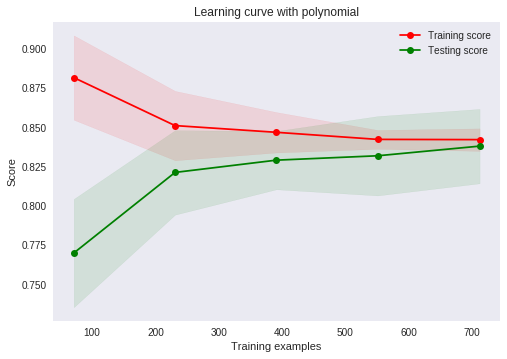

83.8

In [127]:


clf = SVC(kernel="poly")
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
plot_learning_curve(clf, "Learning curve with polynomial", X, y, None, cv=k_fold, n_jobs=4)
plt.show()
round(np.mean(score)*100,2)
  


In [25]:
round(np.mean(score)*100,2)

83.74

### Neural Networks

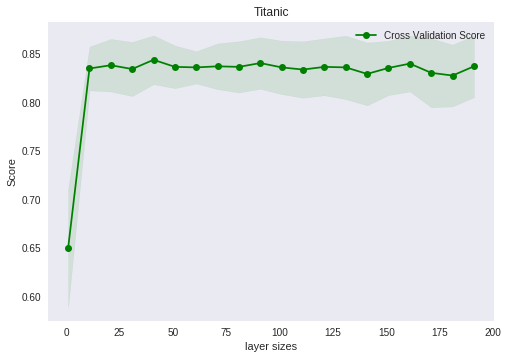

[0.81564246 0.78212291 0.81564246 0.79329609 0.84916201 0.83798883
 0.81564246 0.86592179 0.89385475 0.88268156]


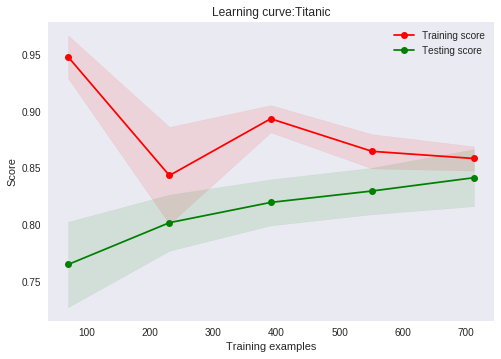

In [113]:
max_depth = []
scores_mean = []
scores_std = []
for _ in range(1, 200, 10):
  clf = MLPClassifier(hidden_layer_sizes=(_, _, _), max_iter=600)
  cv_score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='accuracy')
  scores_mean.append(cv_score.mean())
  scores_std.append(cv_score.std())
  max_depth.append(_)
plot_mean_std(max_depth, scores_mean, scores_std, 
              'Cross Validation Score', 'Titanic', 'layer sizes', 'Score')
plt.show()
  
clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=100)
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, 
                        scoring=scoring)
print(score)
plot_learning_curve(clf, "Learning curve:Titanic", X, y, None, 
                    cv=k_fold, n_jobs=4)
plt.show()

In [111]:
round(np.mean(score)*100,2)

83.74